In [1]:
import ee
ee.Initialize()

We are going to look at four different satellites.

COPERNICUS/S2: SENTINEL 2:   2 satellites (Sentinel 2A (from June 2015) and 2B(from March 2017)) 180 degrees apart in same orbit.  10-day revisit cycle for each one.

LANDSAT/LC08/C01/T1_SR:  LANDSAT 8: (from Feb 2013)

LANDSAT/LT05/C01/T1_SR:  LANDSAT 5: (from 1984)

LANDSAT/LT04/C01/T1_SR:  LANDSAT 4 (from 1982-93):


Define the coordinates we'll use - this is a point in the Sahel, in South Sudan.

In [2]:
coords = [27.95,11.57]
geom = ee.Geometry.Point(coords)

Function to get the unix timestamps of all images in a chosen ImageCollection (i.e. satellite) from Google Earth Engine.

In [3]:
def get_datetimes(collection_name, coords):
    geom = ee.Geometry.Point(coords)
    image_coll = ee.ImageCollection(collection_name).filterBounds(geom)
    def accumulate_timestamps(image, timestamps):
        ts = image.get('system:time_start')
        new_list = ee.List(timestamps)
        return ee.List(new_list.add(ts))
    ts_list = image_coll.iterate(accumulate_timestamps, ee.List([]))
    return ts_list.getInfo()

We want to make a dataframe with date index and log(time difference between successive images) columns.

In [4]:
import numpy as np
import pandas as pd
from datetime import datetime
def make_dataframe(timestamp_list):
    diffs = [int((timestamp_list[i] - timestamp_list[i-1])/1000) for i in range(1,len(timestamp_list))]
    log_diffs = [np.log(tsdiff) for tsdiff in diffs if tsdiff > 0]
    dates = [datetime.fromtimestamp(ts/1000) for ts in timestamp_list[1:]]
    timestamps = [ts/1000 for ts in timestamp_list[1:]]
    months = [str(date)[:7] for date in dates]
    df = pd.DataFrame({"Date": dates, "timestamp": timestamps, "diffs": diffs, "month": months})
    ## filter to exclude duplicate times
    df = df[df["diffs"] > 0]
    ## add log_diffs column, which was only computed for non-zero time differences.
    df["log_diffs"] = log_diffs
    return df


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

Make a 2D histogram, with time on the x-axis, and log(time diff between successive images) on the y-axis.

In [6]:
def create_2d_hist(df):
    num_months = len(df["month"].unique())
    H,xedges,yedges = np.histogram2d(df['timestamp'], df['log_diffs'], bins=[num_months,40],
                                    range =[[df['timestamp'].min(),df['timestamp'].max()],[10,20]] )
    to_datetime = np.vectorize(datetime.fromtimestamp)
    xedges_datetime = to_datetime(xedges)
    return H, xedges_datetime, yedges 


Make this histogram for all four satellites we're considering:

/Users/nbarlow/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


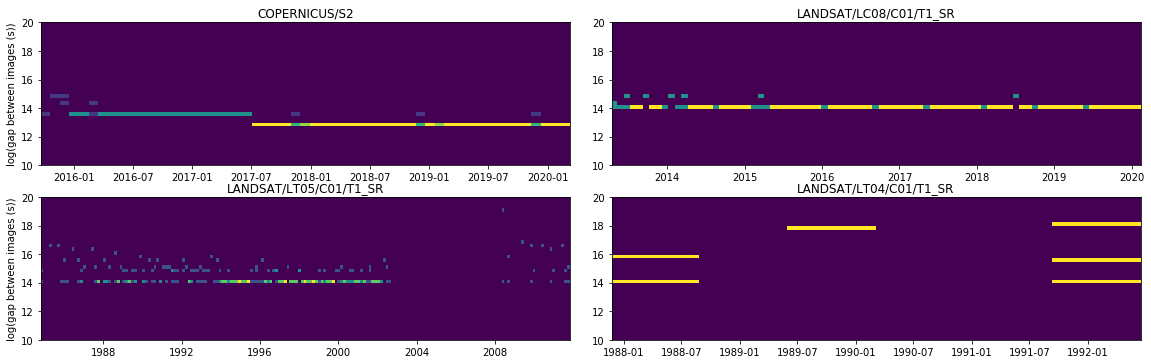

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16,5))
fig.tight_layout()
image_colls = ["COPERNICUS/S2",
               "LANDSAT/LC08/C01/T1_SR",
               "LANDSAT/LT05/C01/T1_SR",
               "LANDSAT/LT04/C01/T1_SR"]
for i, ic in enumerate(image_colls):
    timestamps = get_datetimes(ic, coords)
    dataframe = make_dataframe(timestamps)
    H, xedges, yedges = create_2d_hist(dataframe)
    fig_row = (i//2) 
    fig_col = i%2
    axes[fig_row][fig_col].pcolor(xedges, yedges, H.T)
    axes[fig_row][fig_col].set_title(ic)
    if fig_col == 0:
        axes[fig_row][fig_col].set_ylabel('log(gap between images (s))')

Utility function so we can quickly convert log(time-in-seconds) to number of days:

In [8]:
def gap_converter(log_diff):
    n_days = pow(np.e, log_diff)/(3600*24)
    print(" {0:.2f} days".format( n_days))


In [9]:
gap_converter(16.)

 102.85 days
